# Dst Forecasting via LSTM

In this notebook, I mirror the approach in the sister notebook [First Zonal Harmonic Forecasting via LSTM](forecasting_q10_LSTM.ipynb) to test the differences in forecasting between the two closely related time series. The Dst measurements come from the OMNI dataset, and all other input data are the same as from the sister notebook.

In [126]:
# general
import numpy as np
from sklearn import preprocessing
from scipy.stats import kde
from scipy import signal
import os
import datetime as dt

# deep learning
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, Dropout

# file management, io
import pandas as pd
import h5py

# plotting
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

## Load Data

Let's load the data without gaps as well as the external coefficients.

In [2]:
omni_lr = pd.read_hdf('omni_hourly_1998-2017_nogaps.h5')
dst = omni_lr['Dst-index, nT']
#omni_lr = omni_lr.drop('Dst-index, nT', axis=1)

nfeatin = omni_lr.shape[1]
ndat = omni_lr.shape[0]
t = np.linspace(1998, 2018, ndat+1)[0:-1]

The OMNI series are centered on the hour beginning at 0:00, but contain data averaged throughout the subsequent hour (i.e. hour 0 contains data averaged from 0:00-1:00). The data span from 0:00 January 1, 1998 to 23:00 December 31, 2017, UT. 

For now, I'll include previous values of Dst in the prediction, although ideally knowledge of the other variables would be sufficient to generate a successful model.

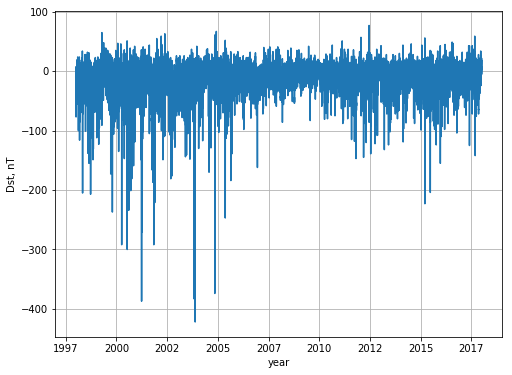

In [3]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(t,dst)
ax.set_ylabel('Dst, nT')
ax.set_xlabel('year')
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
plt.grid(True)
plt.show()

## LSTM
Having imported the data, let's design, train, and test the LSTM network for this prediction problem.

### Stateless architecture

In this architecture, only batches of a given batch-size matter, with the LSTM's being trained exclusively on windows of data of size batch-size. 

In [121]:
"""
From a data array with observations in rows and features in columns, split 
split into testing and training data based on which rows to use (datain_idx), 
batch_sizes, which features for prediction (incols) and which features as 
targest (outcols). Since we're concerned with time series forecasting, the 
number of steps to forecast ahead is lahead.

IN:
data_in: 
data_out: 
batch_size:
train_percent:
lahead:

OUT:
data_in_train:
data_out_train:
data_in_test:
data_out_test:

 """
def datasplit(data_in, data_out, batch_size, train_percent=0.8, lahead=1):
    nfeatin = data_in.shape[1]
    
    data_in = data_in[0:-lahead,:]
    data_out = data_out[lahead:,:]
    
    nbatch = int(np.floor(data_in.shape[0]/batch_size))
    
    # now construct training and testing sets
    batchrand = np.random.permutation(int(nbatch))
    trainbatch = batchrand[0:int(train_percent*nbatch)]
    testbatch = batchrand[int(train_percent*nbatch):]
    
    trainidx = np.zeros(data_in.shape[0],dtype=bool)
    for batchidx in trainbatch:
        trainidx[batchidx*batch_size:batch_size*(batchidx + 1)] = True
        
    testidx = np.zeros(data_out.shape[0],dtype=bool)
    for batchidx in testbatch:
        testidx[batchidx*batch_size:batch_size*(batchidx + 1)] = True
    
    data_in_train = data_in[trainidx,:]
    data_out_train = data_out[trainidx,:]
    data_in_test = data_in[testidx,:]
    data_out_test = data_out[testidx,:]
    return data_in_train, data_out_train, data_in_test, data_out_test



"""
Given a batch size and training data, train network on the data, and
return the trained network

IN:
dat_in_train (np.ndarray): data inputs with shape (ndata, 1, nfeat_in)
dat_out_train (np.ndarray): data outputs with shape (ndata, nfeat_out)
batch_size (int/double):
nunits (int/double): (default 400) number of hidden units in LSTM
epochs (int): (default 100) epochs for training

OUT:
rnn (keras.Sequential): trained network
hist ()
"""
def train_network(dat_in_train, dat_out_train, batch_size, nunits=100, \
                  epochs=100):
    assert len(dat_in_train.shape) == 3, 'check shape of dat_in_train'
    assert len(dat_out_train.shape) == 2, 'check shape of dat_out_train'
    
    nfeat_in = dat_in_train.shape[2]
    nfeat_out = dat_out_train.shape[1]
    
    # recurrent architecture, create input and output datasets
    rnn = Sequential()
    
    rnn.add(LSTM(nunits, 
            name='LSTM_1',
            stateful=False,
            input_shape=(1,nfeat_in),
            batch_size=batch_size,
            return_sequences=False,
            activation='relu'))
    #rnn.add(Dropout(0.25))
    rnn.add(Dense(nfeat_out,
                  name='Dense'))
    opt = keras.optimizers.RMSprop()
    rnn.compile(loss='mse',optimizer=opt)
    # fit model
    hist = rnn.fit(dat_in_train,
            dat_out_train,
            epochs=epochs,
            batch_size=batch_size,
            shuffle=False,
            verbose=1)
    hist = hist.history['loss']
    return rnn, hist

### Stateful architecture

In this architecture, we train the network on the entire series from 1998 to 2015, and then we test on 2016 and 2017. 

In [59]:
"""
From a data array with observations in rows and features in columns, split 
split into testing and training data based on which rows to use (datain_idx), 
batch_sizes, which features for prediction (incols) and which features as 
targest (outcols). Since we're concerned with time series forecasting, the 
number of steps to forecast ahead is lahead.

IN:
data_in: 
data_out: 
batch_size:
train_percent:
lahead:

OUT:
data_in_train:
data_out_train:
data_in_test:
data_out_test:

 """
def datasplit(data_in, data_out, batch_size, train_percent=0.8, lahead=1):
    nfeatin = data_in.shape[1]
    
    data_in = data_in[0:-lahead,:]
    data_out = data_out[lahead:,:]
    
    ndat = data_in.shape[0]
    # limit for training data
    lidx = int((train_percent*ndat)-((train_percent*ndat) % batch_size))
    # limit for testing data
    ridx = int(ndat - (ndat % batch_size))
    
    trainidx = np.zeros(ndat,dtype=bool)
    trainidx[0:lidx] = True
    testidx = np.zeros(ndat,dtype=bool)
    testidx[lidx:ridx] = True
    
    data_in_train = data_in[trainidx,:]
    data_out_train = data_out[trainidx,:]
    data_in_test = data_in[testidx,:]
    data_out_test = data_out[testidx,:]
    return data_in_train, data_out_train, data_in_test, data_out_test



"""
Given a batch size and training data, train network on the data, and
return the trained network

IN:
dat_in_train (np.ndarray): data inputs with shape (ndata, 1, nfeat_in)
dat_out_train (np.ndarray): data outputs with shape (ndata, nfeat_out)
batch_size (int/double):
nunits (int/double): (default 400) number of hidden units in LSTM
epochs (int): (default 100) epochs for training

OUT:
rnn (keras.Sequential): trained network
hist ()
"""
def train_network(dat_in_train, dat_out_train, batch_size, nunits=100, \
                  epochs=100):
    assert len(dat_in_train.shape) == 3, 'check shape of dat_in_train'
    assert len(dat_out_train.shape) == 2, 'check shape of dat_out_train'
    
    nfeat_in = dat_in_train.shape[2]
    nfeat_out = dat_out_train.shape[1]
    
    # recurrent architecture, create input and output datasets
    rnn = Sequential()
    
    rnn.add(LSTM(nunits, 
            name='LSTM_1',
            stateful=True,
            input_shape=(1,nfeat_in),
            batch_size=batch_size,
            return_sequences=False,
            activation='relu'))
    #rnn.add(Dropout(0.02))
    rnn.add(Dense(nfeat_out,
                  name='Dense'))
    opt = keras.optimizers.RMSprop()
    rnn.compile(loss='mse',optimizer=opt)
    # fit model
    hist = np.zeros(epochs)
    for ii in range(epochs):
        rnn.reset_states()
        tmp = rnn.fit(dat_in_train,
            dat_out_train,
            epochs=1,
            batch_size=batch_size,
            shuffle=False,
            verbose=0)
        hist[ii] = tmp.history['loss'][0]
        print('Epoch %d, Loss %1.2e' % (ii, hist[ii]))
    return rnn, hist

### Common Functions

In [152]:
"""
Given a trained network, evaluated it on testing data and plot the
scatter plots.

IN:
dat_in_test (np.ndarray): data inputs with shape (ndata, 1, nfeat_in)
dat_out_test (np.ndarray): data outputs with shape (ndata, nfeat_out)
rnn (keras.Sequential): trained network
batch_size (int/double):
feature_names (list): list of names of output features, length nfeat_out

OUT:
produces plot

"""
def test_network(dat_in_test, dat_out_test, rnn, batch_size, feature_names):
    assert len(dat_in_test.shape) == 3, 'check shape of dat_in_test'
    assert len(dat_out_test.shape) == 2, 'check shape of dat_out_test'
    nfeat_out = dat_out_test.shape[1]
    rnn.reset_states()
    dat_pred = rnn.predict(dat_in_test,batch_size=batch_size)
    plt.figure()
    curtest = np.concatenate((scaler_output.inverse_transform(dat_out_test),\
                              scaler_output.inverse_transform(dat_pred)), axis=1)
    plotcorr(curtest, title=feature_names)
    return dat_pred

"""
Plot straight line in current axis.
"""
def abline(slope, intercept):
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, 'k--')
    
"""
Plot scatter plot with 1:1 line and point density contours.
IN:
data (nd.array): ndata x 2 array
"""
def plotcorr(data, title=''):
    plt.scatter(data[:,0], data[:,1], marker='.')
    k = kde.gaussian_kde(data.T)
    x, y = data.T
    nbins = 50
    xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))                                      
    plt.contour(xi,yi,zi.reshape(xi.shape), 10)
    abline(1,0)
    r2 = np.corrcoef(data[:,0], data[:,1])[0,1]**2
    plt.title('%s, $r^2$ = %1.2f' % (title, r2))
    plt.show()

### Split and Prepare Data

Let's separate the data into training and testing sets. Let's also normalize all of the data according to the training data.

In [123]:
batch_size = 150
lahead = 6
train_percent = 0.8

In [124]:
# split
data_in_train, data_out_train, data_in_test, data_out_test = datasplit(omni_lr.values, dst.values.reshape(-1,1), batch_size, train_percent, lahead)

# normalize
scaler_input = preprocessing.MinMaxScaler(feature_range=(0,1))
data_in_train = scaler_input.fit_transform(data_in_train)
data_in_test = scaler_input.transform(data_in_test)

scaler_output = preprocessing.MinMaxScaler(feature_range=(0,1))
data_out_train = scaler_output.fit_transform(data_out_train)
data_out_test = scaler_output.transform(data_out_test)

# reshape input data
data_in_train = data_in_train.reshape(-1,1,nfeatin)
data_in_test = data_in_test.reshape(-1,1,nfeatin)

C:\Users\Adrian\.julia\packages\Conda\m7vem\deps\usr\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Epoch 1/100
140100/140100 [==============================] - 5s 33us/step - loss: 0.0112
Epoch 2/100
140100/140100 [==============================] - 4s 25us/step - loss: 8.6271e-04
Epoch 3/100
140100/140100 [==============================] - 4s 25us/step - loss: 7.6200e-04
Epoch 4/100
140100/140100 [==============================] - 4s 25us/step - loss: 7.0832e-04
Epoch 5/100
140100/140100 [==============================] - 4s 25us/step - loss: 6.7668e-04
Epoch 6/100
140100/140100 [==============================] - 4s 25us/step - loss: 6.5892e-04
Epoch 7/100
140100/140100 [==============================] - 4s 27us/step - loss: 6.4339e-04
Epoch 8/100
140100/140100 [==============================] - 4s 28us/step - loss: 6.3246e-04
Epoch 9/100
140100/140100 [==============================] - 4s 27us/step - loss: 6.2316e-04
Epoch 10/100
140100/140100 [==============================] - 4s 25us/step - loss: 6.1599e-04
Epoch 11/100
140100/140100 [==============================] - 4s 25us/ste

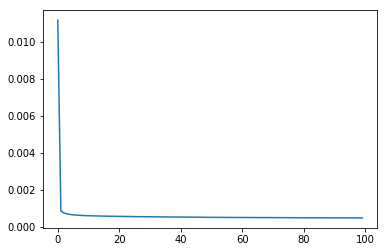

In [128]:
rnn, hist = train_network(data_in_train, data_out_train, batch_size, epochs=100)
plt.plot(hist)

### Test

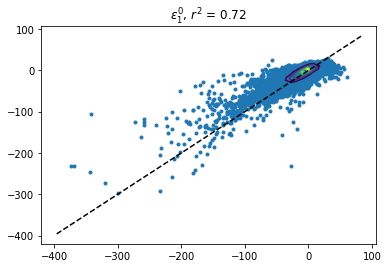

In [153]:
data_out_pred = test_network(data_in_test, data_out_test, rnn, batch_size,'$\epsilon_1^0$')

### Discuss

The best published result to date for t+6 prediction is that reported by Gruet et al. 2018, who achieve $R$=0.873 ($R^2$ = 0.762) on data from 2001-2016. This result is certainly an improvement over predicting by taking the last observed Dst value, whose correlation is then the hourly autocorrelation of lag 6 (the full autocorrelation function is shown below for various lags).

C:\Users\Adrian\.julia\packages\Conda\m7vem\deps\usr\lib\site-packages\scipy\signal\signaltools.py:491: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[reverse].conj()
C:\Users\Adrian\.julia\packages\Conda\m7vem\deps\usr\lib\site-packages\mkl_fft\_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


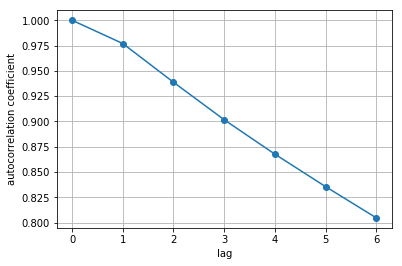

In [142]:
dstnorm = (dst-np.mean(dst))/np.std(dst)
dstcor = signal.correlate(dstnorm, dstnorm)/len(dstnorm)
idx = int(len(dstcor)/2)

plt.plot(dstcor[idx:idx+7],'o-')
plt.xlabel('lag')
plt.ylabel('autocorrelation coefficient')
plt.grid(True)

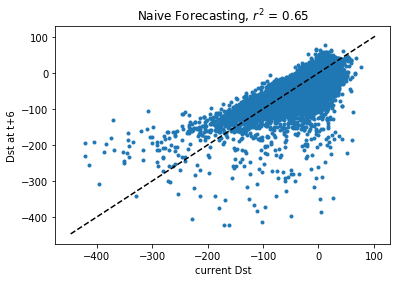

In [151]:
plt.scatter(dst[0:-6], dst[6:], marker='.')
abline(1, 0)
plt.xlabel('current Dst')
plt.ylabel('Dst at t+6')
plt.title('Naive Forecasting, $r^2$ = %1.2f' % dstcor[idx+6]**2)

plt.show()

In [ ]:
plotcorr(np.concatenate(dst))

Previous results tabulated (ADD TABLE) show that all neural networks except Gruet's and Wu & Lundstedt (1997) are unable (for t+6 prediction) to even replicate the results of the most basic prediction, which is to take the current value as a prediction for the value in 6 hours. This approach, as shown by the autocorrelation function, achieves $R$ = 0.804$, so to be considered an improvement over completely ignorant estimation, the neural network needs to achieve a higher correlation coefficient. 